https://medium.com/@sahin.samia/the-math-behind-deepseek-a-deep-dive-into-group-relative-policy-optimization-grpo-8a75007491ba

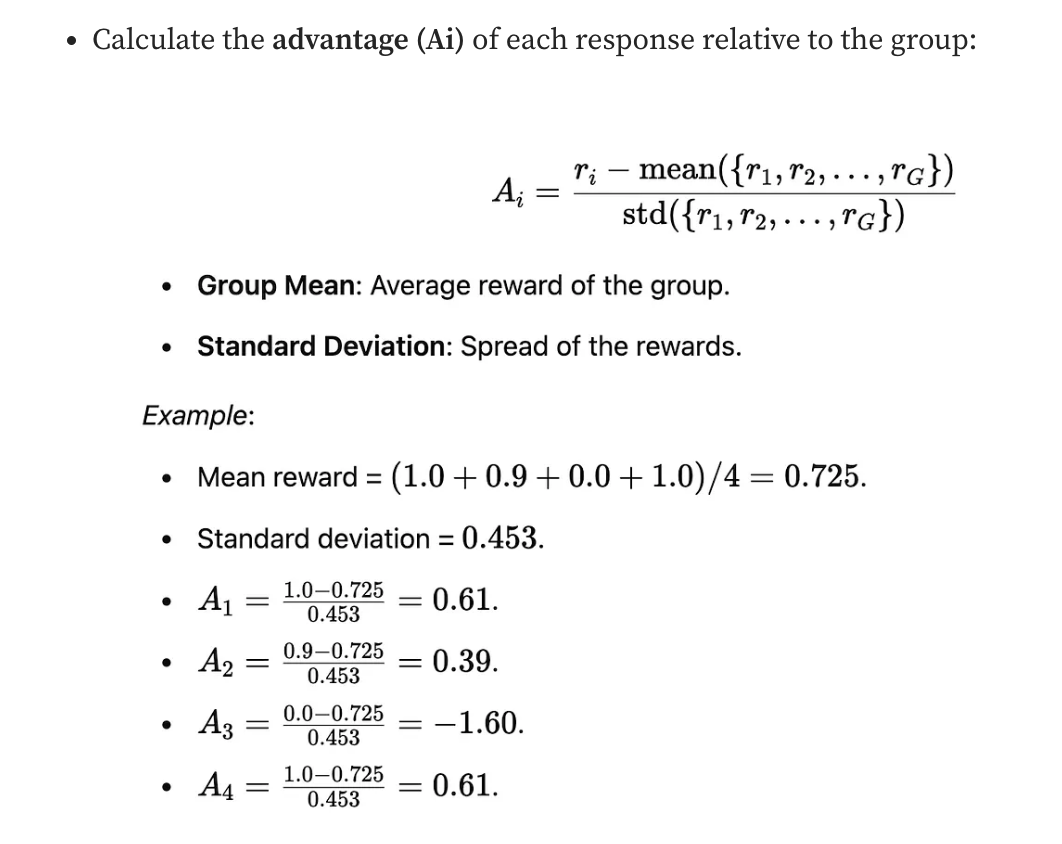

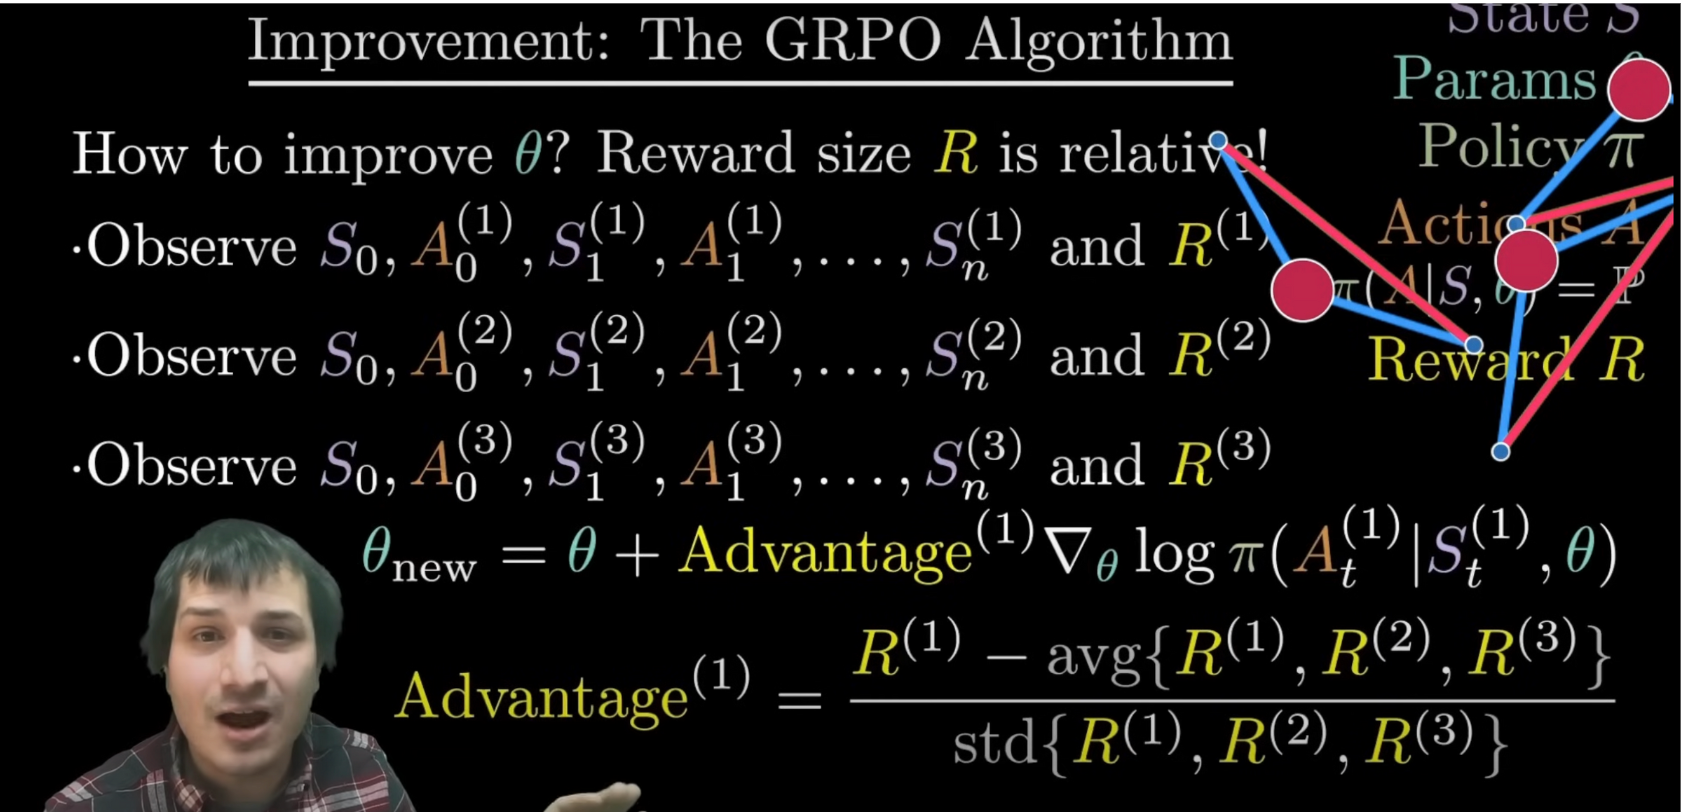

Training the policy with GRPO:
Episode 0, Average Reward (last 50): 11.00
Episode 50, Average Reward (last 50): 27.62
Episode 100, Average Reward (last 50): 55.12
Episode 150, Average Reward (last 50): 75.02
Episode 200, Average Reward (last 50): 123.86
Episode 250, Average Reward (last 50): 241.88
Episode 300, Average Reward (last 50): 364.68
Episode 350, Average Reward (last 50): 394.16
Episode 400, Average Reward (last 50): 451.14
Episode 450, Average Reward (last 50): 478.30
Episode 500, Average Reward (last 50): 450.90
Episode 550, Average Reward (last 50): 484.32
Episode 600, Average Reward (last 50): 472.22
Episode 650, Average Reward (last 50): 487.50
Episode 700, Average Reward (last 50): 497.24
Episode 750, Average Reward (last 50): 500.00
Episode 800, Average Reward (last 50): 500.00
Episode 850, Average Reward (last 50): 500.00
Episode 900, Average Reward (last 50): 500.00
Episode 950, Average Reward (last 50): 500.00
Episode 1000, Average Reward (last 50): 500.00
Episode 1

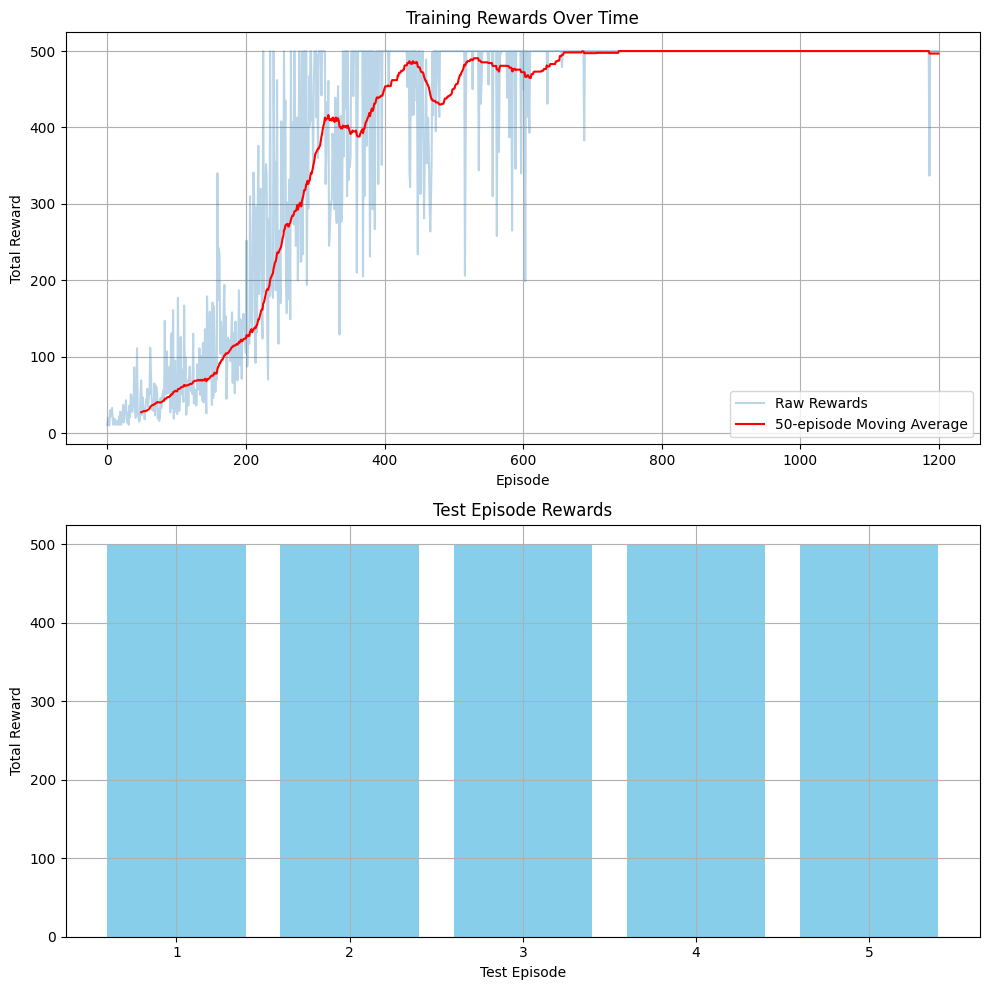

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython import display

# Hyperparameters
learning_rate = 0.01
gamma = 0.99
num_episodes = 1200
max_steps = 500
render_training = False
group_size = 10  # New hyperparameter for GRPO
beta = 0.25       # Weighting factor for relative advantage

# Neural Network Policy
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

# Main training function with GRPO
def train(render=render_training):
    """Train the policy network using Group Relative Policy Optimization."""
    env = gym.make('CartPole-v1', render_mode='rgb_array' if render else None)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    policy = PolicyNetwork(state_dim, 128, action_dim)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    
    episode_rewards = []
    trajectory_buffer = []  # Store trajectories for group comparison
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        states = []
        
        # Collect trajectory
        for t in range(max_steps):
            if render:
                img = env.render()
                plt.imshow(img)
                display.display(plt.gcf())
                display.clear_output(wait=True)
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            m = Categorical(probs)
            action = m.sample()
            log_probs.append(m.log_prob(action))
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            rewards.append(reward)
            states.append(state)
            state = next_state
            if done:
                break
        
        total_reward = sum(rewards)
        trajectory_buffer.append({
            'log_probs': log_probs,
            'rewards': rewards,
            'total_reward': total_reward
        })
        episode_rewards.append(total_reward)
        
        # Update policy when we have enough trajectories for a group
        if len(trajectory_buffer) >= group_size:
            # Compute discounted returns for all trajectories
            all_returns = []
            for traj in trajectory_buffer:
                R = 0
                returns = []
                for r in traj['rewards'][::-1]:
                    R = r + gamma * R
                    returns.insert(0, R)
                all_returns.append(torch.FloatTensor(returns))
            
            # Compute group-relative advantages
            group_returns = torch.tensor([traj['total_reward'] for traj in trajectory_buffer])
            group_mean = group_returns.mean()
            group_std = group_returns.std() + 1e-9
            
            policy_loss = []
            for i, traj in enumerate(trajectory_buffer):
                # Standard normalized returns
                returns = all_returns[i]
                normalized_returns = (returns - returns.mean()) / (returns.std() + 1e-9)
                
                # Group-relative advantage
                relative_adv = (traj['total_reward'] - group_mean) / group_std
                
                # Combined advantage
                for log_prob, ret in zip(traj['log_probs'], normalized_returns):
                    advantage = (1 - beta) * ret + beta * relative_adv
                    policy_loss.append(-log_prob * advantage)
            
            # Update policy
            policy_loss = torch.cat(policy_loss).sum()
            optimizer.zero_grad()
            policy_loss.backward()
            optimizer.step()
            
            # Clear buffer
            trajectory_buffer = []
        
        if episode % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            print(f"Episode {episode}, Average Reward (last 50): {avg_reward:.2f}")
    
    env.close()
    return policy, episode_rewards

# Test function (unchanged)
def test(policy, episodes=5, render=True):
    env = gym.make('CartPole-v1', render_mode='rgb_array' if render else None)
    test_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        for t in range(max_steps):
            if render:
                img = env.render()
                plt.imshow(img)
                display.display(plt.gcf())
                display.clear_output(wait=True)
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            action = torch.argmax(probs).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
            if done:
                break
                
        test_rewards.append(total_reward)
        print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")
    
    env.close()
    return test_rewards

# Plot function (unchanged)
def plot_results(train_rewards, test_rewards):
    window_size = 50
    moving_avg = np.convolve(train_rewards, np.ones(window_size)/window_size, mode='valid')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    ax1.plot(train_rewards, label='Raw Rewards', alpha=0.3)
    ax1.plot(range(window_size-1, len(train_rewards)), moving_avg, 
            label=f'{window_size}-episode Moving Average', color='red')
    ax1.set_title('Training Rewards Over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
    ax1.grid(True)
    
    episodes = range(1, len(test_rewards) + 1)
    ax2.bar(episodes, test_rewards, color='skyblue')
    ax2.set_title('Test Episode Rewards')
    ax2.set_xlabel('Test Episode')
    ax2.set_ylabel('Total Reward')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Training the policy with GRPO:")
    trained_policy, train_rewards = train(render=render_training)
    
    print("\nTesting the trained policy:")
    test_rewards = test(trained_policy, render=False)
    
    print("\nPlotting results:")
    plot_results(train_rewards, test_rewards)